## Harris Corner Detection and Matching

<p style='direction:rtl; text-align: right'>
برای حل این مسئله، ابتدا بر اساس دستورکار روش هریس، ‌امتیاز هریس را به ازای هر پیکسل به دست می‌آوریم. سپس برای NMS، پس از ترشهولد گرفتن، هر بار
پیکسلی که بزرگترین امتیاز هریس را دارد را انتخاب میکنیم و به عنوان یک Interest Point اعلام می‌کنیم. سپس امتیاز تمام پیکسل‌های اطراف این
پیکسل را صفر می‌کنیم تا دیگر انتخاب نشوند. حال دوباره این فرایند را تکرار می‌کنیم تا زمانی که هیچ پیکسلی با امتیاز مثبت هریس وجود نداشته باشد.
<br>
پس از آن، با استفاده از روش گفته شده در صورت تمرین،‌ همسایگی هر Interest point را به عنوان feature vector برای آن در نظر می‌گیریم و
در نهایت به صورت بروت فورس به جست‌وجوی مچ می‌پردازیم. سپس مچ‌هایی که اطمینان زیادی از صحتشان نداریم را نیز حذف می‌کنیم.
</p>

<p style='direction:rtl; text-align: right'>
ایمپورت های لازم را انجام می‌دهیم و تصاویر را از فایل خوانده و نمایش می‌دهیم:
</p>



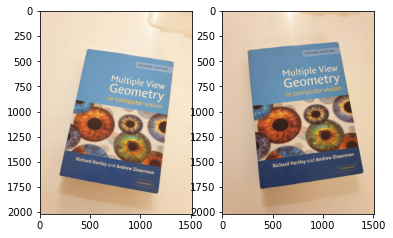

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import util

img1 = util.img_as_float64(plt.imread('./data/hw1/im01.jpg'))
img2 = util.img_as_float64(plt.imread('./data/hw1/im02.jpg'))


def normalized(src):
    return (src - src.min()) / (src.max() - src.min())


def imshow(*srcs):
    plt.close()
    fig, ax = plt.subplots(ncols=len(srcs))
    for i, src in enumerate(srcs):
        t = (src - src.min()) / (src.max() - src.min())
        if (len(srcs)) > 1:
            ax[i].imshow(t, cmap='gray')
        else:
            ax.imshow(t, cmap='gray')
    plt.show()


imshow(img1, img2)

<p style='direction:rtl; text-align: right'>
با استفاده از فیلتر سوبل، مشتق تصویر را به دست می‌آوریم:
</p>

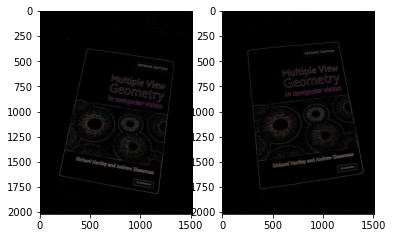

In [2]:
def get_derivatives(src, k_size=3, mag=False):
    d_x = cv.Sobel(src, cv.CV_64F, 1, 0, ksize=k_size, borderType=cv.BORDER_REFLECT101)
    d_y = cv.Sobel(src, cv.CV_64F, 0, 1, ksize=k_size, borderType=cv.BORDER_REFLECT101)
    if mag:
        return np.sqrt(d_x ** 2 + d_y ** 2)
    else:
        return d_x, d_y


img1_d_mag = get_derivatives(img1, mag=True)
img2_d_mag = get_derivatives(img2, mag=True)

imshow(normalized(img1_d_mag), normalized(img2_d_mag))


<p style='direction:rtl; text-align: right'>
با استفاده از مشتق‌های به دست‌ آمده، تانسور ساختار را حساب می‌کنیم. انحراف معیار فیلتر گوسی استفاده شده برای محسابه تانسور،
در ادامه ذکر شده است. سپس امتیاز هریس را با ضریب k که مقدار آن در ادامه ذکر شده است به دست می‌آوریم. این مقدار را به صورت تجربی
به گونه‌ای تعیین میکنیم که گوشه‌ها بیشترین امتیاز هریس را دریافت کنند.
</p>

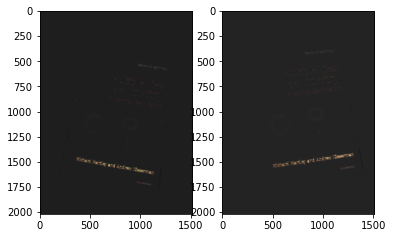

Sigma: 5, Harris parameter(k): 0.05


In [3]:
def get_structure_tensor(src, sigma):
    d_x, d_y = get_derivatives(src)
    d2_x = d_x ** 2
    d2_y = d_y ** 2
    d_xy = d_x * d_y

    k_size = (int(4 * sigma + 1), int(4 * sigma + 1))
    s2_x = cv.GaussianBlur(d2_x, k_size, sigma)
    s2_y = cv.GaussianBlur(d2_y, k_size, sigma)
    s_xy = cv.GaussianBlur(d_xy, k_size, sigma)

    return s2_x, s_xy, s2_y


def calc_harris_score(src, sigma, k):
    s2_x, s_xy, s2_y = get_structure_tensor(src, sigma)

    det = s2_x * s2_y - s_xy ** 2
    tr = s2_x + s2_y

    return det - k * tr ** 2


sigma = 5
k = 0.05
img1_harris_score = calc_harris_score(img1, sigma, k)
img2_harris_score = calc_harris_score(img2, sigma, k)

imshow(normalized(img1_harris_score), normalized(img2_harris_score))
print(f'Sigma: {sigma}, Harris parameter(k): {k}')

<p style='direction:rtl; text-align: right'>
حال مقادیر کوچک و یا منفی را از تصویر هریس حذف می‌کنیم. مقدار آستانه در ادامه ذکر شده‌است.
</p>

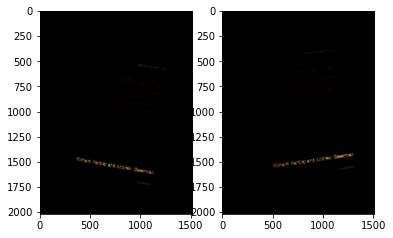

Threshold value: 0.01


In [4]:
thresh = 0.01
img1_harris_score_thresh = np.where(img1_harris_score > thresh, img1_harris_score, 0)
img2_harris_score_thresh = np.where(img2_harris_score > thresh, img2_harris_score, 0)

imshow(normalized(img1_harris_score_thresh), normalized(img2_harris_score_thresh))
print(f'Threshold value: {thresh}')

<p style='direction:rtl; text-align: right'>
حال با همان روشی که در بالا توضیح داده شد، NMS را اعمال می‌کنیم تا بهترین نقاط هر مولفه به دست‌ آیند.
</p>

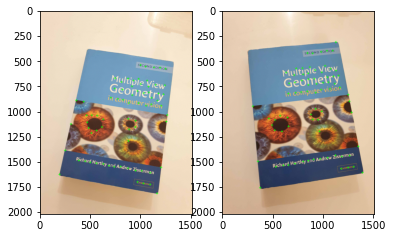

Min distance for harris peaks: 50px


In [5]:
def non_max_suppression(src, min_dist=50, thresh=0.0001):
    src = src.copy()
    coords = []
    while src.max() > thresh:
        coord = np.argmax(src)
        coord = np.unravel_index(coord, src.shape)
        coords.append(coord)
        src[max(0, coord[0] - min_dist):min(src.shape[0], coord[0] + min_dist),
        max(0, coord[1] - min_dist):min(src.shape[1], coord[1] + min_dist)] = 0

    return np.array(coords)[..., :2]


def draw_marker(src, points, marker_size=20, thickness=3):
    src = src.copy()
    for pt in points:
        cv.drawMarker(src, tuple(pt[::-1]), color=(0, 1, 0), markerType=0, markerSize=marker_size, thickness=thickness)
    return src


min_dist = 50
img1_harris_points = non_max_suppression(img1_harris_score_thresh, min_dist, thresh)
img2_harris_points = non_max_suppression(img2_harris_score_thresh, min_dist, thresh)

img1_harris = draw_marker(img1, img1_harris_points)
img2_harris = draw_marker(img2, img2_harris_points)

imshow(img1_harris, img2_harris)
print(f'Min distance for harris peaks: {min_dist}px')


<p style='direction:rtl; text-align: right'>
پس از به دست آمدن نقاط گوشه‌ای، همسایگی هر نقطه را تا فاصله ۳۰ پیکسل، به عنوان feature vector در نظر میگیریم. برای مقایسه
دو بردار نیز، از فاصله Chi-squared متقارن استفاده می‌کنیم.
<br>
سپس نزدیک ترین بردار های دو تصویر را مچ میکنیم ولی تنها نقاطی را نگه می‌داریم که به نسبت 0.8 از بهترین مچ بعدی فاصله دارند.
</p>

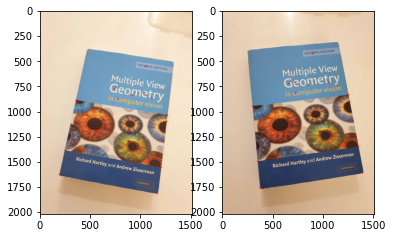

Matching ratio threshold: 0.8


In [6]:
def get_neighborhood(src, pt, dist):
    return src[max(0, pt[0] - dist):min(src.shape[0], pt[0] + dist),
           max(0, pt[1] - dist):min(src.shape[1], pt[1] + dist)]


def get_feature_vector(src, pt):
    return get_neighborhood(src, pt, 30).ravel()


def get_features_distance(fv1, fv2):
    return cv.compareHist(fv1.astype(np.float32), fv2.astype(np.float32), cv.HISTCMP_CHISQR_ALT)


img1_feature_vectors = [get_feature_vector(img1, pt) for pt in img1_harris_points]
img2_feature_vectors = [get_feature_vector(img2, pt) for pt in img2_harris_points]

dist = np.array([[get_features_distance(feature_vector1, feature_vector2)
                  for feature_vector2 in img2_feature_vectors]
                 for feature_vector1 in img1_feature_vectors])

match_threshold = 0.8

match_for_img1 = -np.ones(dist.shape[0], dtype=int)
match_for_img2 = -np.ones(dist.shape[1], dtype=int)

for i in range(dist.shape[0]):
    srt = np.argsort(dist[i, :])
    p1, p2 = srt[0], srt[1]
    d1, d2 = dist[i, [p1, p2]]
    if d1 / d2 < match_threshold:
        match_for_img1[i] = p1

for i in range(dist.shape[1]):
    srt = np.argsort(dist[:, i])
    p1, p2 = srt[0], srt[1]
    d1, d2 = dist[[p1, p2], i]
    if d1 / d2 < match_threshold:
        match_for_img2[i] = p1

img1_corres = img1.copy()
img2_corres = img2.copy()

for i, m in enumerate(match_for_img1):
    if m != -1 and match_for_img2[m] == i:
        cv.drawMarker(img1_corres, tuple(img1_harris_points[i][::-1]),
                      color=(1, 0, 0), markerType=0, markerSize=20, thickness=3)
        cv.drawMarker(img2_corres, tuple(img2_harris_points[m][::-1]),
                      color=(1, 0, 0), markerType=0, markerSize=20, thickness=3)

imshow(img1_corres, img2_corres)
print(f'Matching ratio threshold: {match_threshold}')

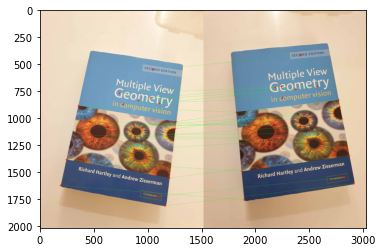

In [7]:
img_side_by_side = np.concatenate([img1_corres, img2_corres], axis=1)
for i, m in enumerate(match_for_img1):
    if m != -1 and match_for_img2[m] == i:
        cv.line(img_side_by_side, tuple(img1_harris_points[i][::-1]),
                tuple(img2_harris_points[m][::-1] + np.array([img1.shape[1], 0]))
                , color=(0, 1, 0), thickness=1)

imshow(img_side_by_side)

